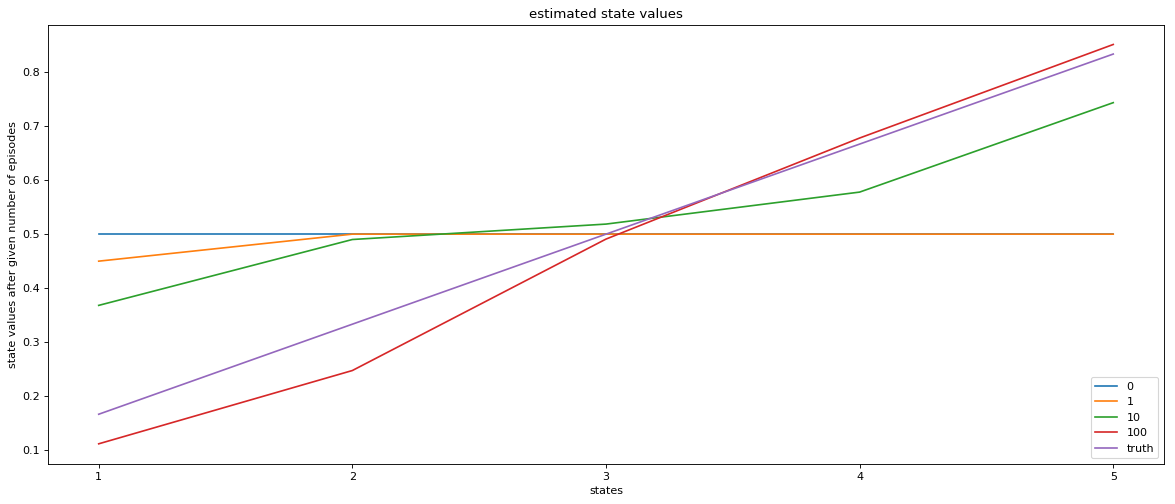

In [58]:
#random walk left graph

import numpy as np
import random
import matplotlib.pyplot as plt
import copy

#################initialization

state_values=[0.5 for i in range(7)]
state_values[0]=0; state_values[6]=0; #terminal states

gamma=1 #undiscounted
alpha=0.1 #constant_step 

##########################TD(0) predicting state_values

def choose(s): #used to get the next state and reward, starting from the current state - s
    if(s==0 or s==6): #terminal states
        return [0,s]
    val=random.randint(1,2) #to go left or right
    if(val==1):
        return [0,s-1]
    else:
        if(s==5):
            return [1,6]
        return [0,s+1]
        
def td_0_prediction(state_values,num_ep,gamma,alpha):
    out=[copy.deepcopy(state_values)] #this is a list: each element is a list of state values at end of 0th, 1st, 10th and 100th episode 
    
    for ep in range(num_ep):
        s=3 #initial state
        while(s!=0 and s!=6):
            [r,s_next]=choose(s) #get the next state and 
            
            state_values[s]= state_values[s] + alpha*(r + (gamma*state_values[s_next]) - state_values[s]) #state_value evaluation via bootstrapping
            
            s=s_next #go to the next state(make it the current state for next step)
        
        if(ep==0 or ep==9 or ep==99):
            out.append(copy.deepcopy(state_values))
    
    return out


out=td_0_prediction(copy.deepcopy(state_values),100,gamma,alpha) #td(0) ran for 100 episodes

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.title("estimated state values");plt.xlabel("states");plt.ylabel('state values after given number of episodes')
plt.xticks([i+1 for i in range(5)])
plt.plot([i+1 for i in range(5)],out[0][1:6],label='0')
plt.plot([i+1 for i in range(5)],out[1][1:6],label='1')
plt.plot([i+1 for i in range(5)],out[2][1:6],label='10')
plt.plot([i+1 for i in range(5)],out[3][1:6],label='100')
plt.plot([i+1 for i in range(5)],[1/6,2/6,3/6,4/6,5/6],label='truth')

plt.legend(loc='lower right')


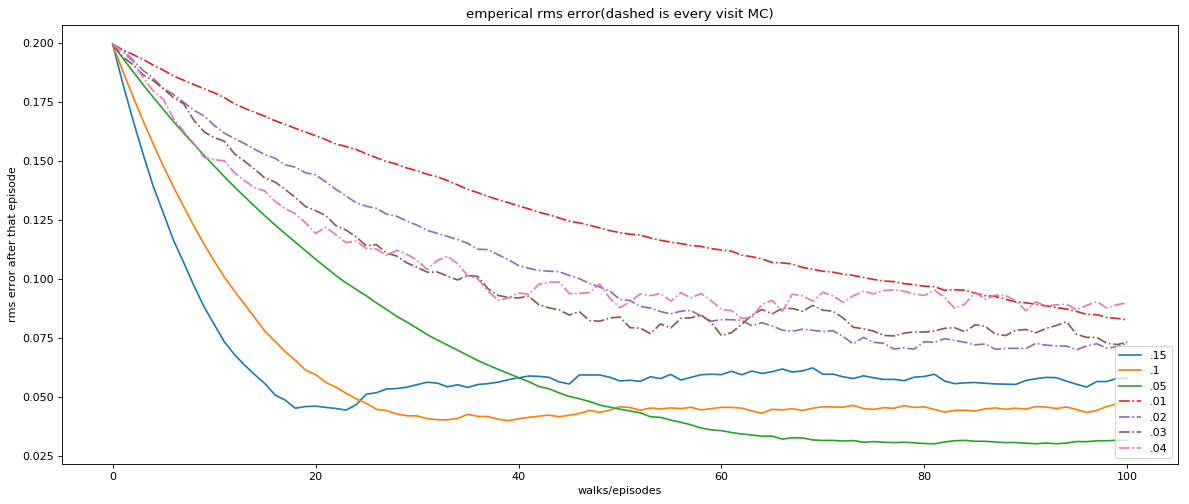

In [33]:
#random walk right graph

import numpy as np
import random
import matplotlib.pyplot as plt
import copy


##########################initializations

state_values=[0.5 for i in range(7)]
state_values[0]=0; state_values[6]=0;


gamma=1 #undiscounted
alpha=0.1 #constant_step 

##################################first-visit MC

def an_episode(): #generates a sequence of episodes for MC
    s=3
    states=[s]
    rewards=[]
    while(states[-1]!=0 and states[-1]!=6):
        val=random.randint(1,2)
        if(val==1):
            s=s-1
        else:
            s=s+1
        states.append(s)
        
        if(s==6):
            rewards.append(1)
        else:
            rewards.append(0)
    
    rewards.append(0)
    return [states,rewards]
    
def first_visit_MC(num_ep,state_values,gamma,alpha,truth):
    err=0 #rms evaluation at 0th episode
    for i in range(1,len(truth)-1):
        err+=(truth[i]-state_values[i])**2
    err=(err/len(truth))**(1/2)
    out=[err] #holds the rms error for each episode
    
    for ep in range(num_ep):
        [states,rewards]=an_episode() #getting an entire episode
        G=0 #return initialized
        
        for i in range(len(rewards)-1,-1,-1): #iterating through each step of the episode
            
            G=(gamma*G)+rewards[i] #return updated
                
            #constant alpha method of updation
            state_values[states[i]]+=(G-state_values[states[i]])*alpha
        
        err=0 #subsequent rms evaluations
        for i in range(1,len(truth)-1):
            err+=(truth[i]-state_values[i])**2
        err=(err/len(truth))**(1/2)
        out.append(err)
        
    return out

###################################TD(0)
def choose(s):
    if(s==0 or s==6):
        return [0,s]
    val=random.randint(1,2)
    if(val==1):
        return [0,s-1]
    else:
        if(s==5):
            return [1,6]
        return [0,s+1]
    
def td_0_prediction(state_values,num_ep,gamma,alpha,truth):
    err=0
    for i in range(1,len(truth)-1):
        err+=(truth[i]-state_values[i])**2
    err=(err/len(truth))**(1/2)
    out=[err]
    
    for ep in range(num_ep):
        s=3
        while(s!=0 and s!=6):
            [r,s_next]=choose(s)
            
            state_values[s]= state_values[s] + alpha*(r + (gamma*state_values[s_next]) - state_values[s])
            
            s=s_next
        
        err=0
        for i in range(1,len(truth)-1):
            err+=(truth[i]-state_values[i])**2
        err=(err/len(truth))**(1/2)
        out.append(err)
    
    return out

################################################driver for TD

out15=[0 for i in range(101)];out1=[0 for i in range(101)];out05=[0 for i in range(101)]
for i in range(100): #averaging over 100 runs
    a1=td_0_prediction(copy.deepcopy(state_values),100,gamma,0.15,[0,1/6,2/6,3/6,4/6,5/6,0])
    a2=td_0_prediction(copy.deepcopy(state_values),100,gamma,0.1,[0,1/6,2/6,3/6,4/6,5/6,0])
    a3=td_0_prediction(copy.deepcopy(state_values),100,gamma,0.05,[0,1/6,2/6,3/6,4/6,5/6,0])
    
    for j in range(len(a1)):
        out15[j]+=a1[j]/100
        out1[j]+=a2[j]/100
        out05[j]+=a3[j]/100

#############################################plotting for TD

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.title("emperical rms error(dashed is every visit MC)");plt.xlabel("walks/episodes");plt.ylabel('rms error after that episode')
# plt.xticks([i+1 for i in range(5)])
plt.plot([i for i in range(len(out15))],out15,label='.15')
plt.plot([i for i in range(len(out1))],out1,label='.1')
plt.plot([i for i in range(len(out05))],out05,label='.05')

###################################################################driver for MC

out01=[0 for i in range(101)];out02=[0 for i in range(101)];out03=[0 for i in range(101)];out04=[0 for i in range(101)]
for i in range(100): #averaging over 100 runs
    a01=first_visit_MC(100,copy.deepcopy(state_values),gamma,0.01,[0,1/6,2/6,3/6,4/6,5/6,0])
    a02=first_visit_MC(100,copy.deepcopy(state_values),gamma,0.02,[0,1/6,2/6,3/6,4/6,5/6,0])
    a03=first_visit_MC(100,copy.deepcopy(state_values),gamma,0.03,[0,1/6,2/6,3/6,4/6,5/6,0])
    a04=first_visit_MC(100,copy.deepcopy(state_values),gamma,0.04,[0,1/6,2/6,3/6,4/6,5/6,0])
    
    
    for j in range(len(a1)):
        out01[j]+=a01[j]/100
        out02[j]+=a02[j]/100
        out03[j]+=a03[j]/100
        out04[j]+=a04[j]/100

###############################################################plotting for MC

plt.plot([i for i in range(len(out01))],out01,'-.',label='.01')
plt.plot([i for i in range(len(out02))],out02,'-.',label='.02')
plt.plot([i for i in range(len(out03))],out03,'-.',label='.03')
plt.plot([i for i in range(len(out04))],out04,'-.',label='.04')

plt.legend(loc='lower right')


1 2 10 21
usabel ace, 500000


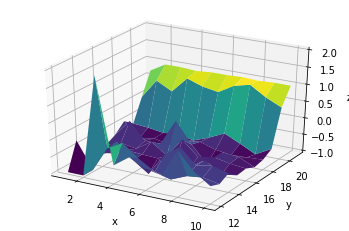

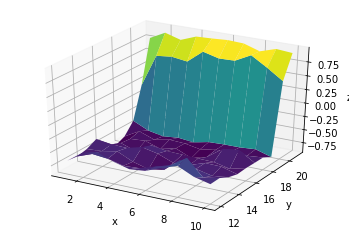

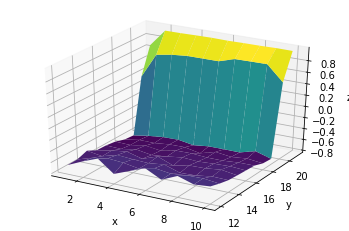

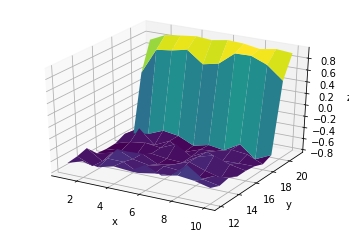

In [23]:
#Q4 Blackjack - part1

import random
import copy

############################################setup

#cards:1-13={Ace,2,3,4,5,6,7,8,9,10,10,10,10}

def deal_card():
    return min(random.randint(1,13),10)
    
    
class dealer():
    def __init__(self,face_up,current_sum,nonu_ace):
        self.face_up=face_up
        self.nonu_ace=nonu_ace
        self.u_ace=0
        self.current_sum=current_sum
        self.update(0)#pass a card number(pass a zero if you want to just update the ace situation)
    
    def update(self,card): #it should be 0<=card<=10
        self.current_sum+=card
        if(card==1 and self.current_sum<11):
            self.u_ace=1
            self.current_sum+=10
            
        if(self.nonu_ace>0 and self.current_sum+10<=21):
            self.nonu_ace-=1
            self.u_ace=1
            self.current_sum+=10
    
    def update_face_up(self,card):
        self.face_up=card
    
    def move(self):
        if(self.current_sum<17):
            return 1 #hit
        return 0 #stick
    
    def reset(self):
        self.face_up=0
        self.nonu_ace=0
        self.u_ace=0
        self.current_sum=0
        self.update(0)#pass a card number(pass a zero if you want to just update the ace situation)
    
    

class player():
    def __init__(self,current_sum,nonu_ace):
        self.nonu_ace=nonu_ace
        self.u_ace=0
        self.current_sum=current_sum
        self.update(0)#pass a card number(pass a zero if you want to just update the ace situation)
    
    def update(self,card): #it should be 0<=card<=10
        self.current_sum+=card;self.nonu_ace+=(card==1)
        if(card==1 and self.current_sum<11):
            self.u_ace=1
            self.nonu_ace-=1
            self.current_sum+=10
            
        if(self.nonu_ace>0 and self.current_sum+10<=21):
            self.nonu_ace-=1
            self.u_ace=1
            self.current_sum+=10
    
    def move(self):
        if(self.current_sum<20):
            return 1 #hit
        return 0 #stick
    
    def reset(self):
        self.nonu_ace=0
        self.u_ace=0
        self.current_sum=0
        self.update(0)#pass a card number(pass a zero if you want to just update the ace situation)
    
########################################################### initialization

# rewards = [0,1,-1]
    
state_values={} #state_values[s:(i,j,k)][a]
for i in range(2,22): #current states s: current_sum  of player
    for j in range(1,11): #current states s: dealer's showing card '1 is ace'
        for k in range(0,2): #current states s: user has usable ace or not '0 means no, 1 means yes'
            state_values[(i,j,k)]=random.randint(1,5)
#             m=[random.randint(1,5) for i in range(2)] #actions [0-stick, 1-hit]
#             state_values[(i,j,k)]=m
        
y=[i[0] for i in state_values]; x=[i[1] for i in state_values];print(min(x),min(y),max(x),max(y))
gamma=1

#########################################################first-visit MC

def game_episode(Player,Dealer):
    
    #dealing cards
    face_up=deal_card()
    Dealer.update_face_up(face_up)
    Dealer.update(face_up);Dealer.update(deal_card())
    
    Player.update(deal_card());Player.update(deal_card())
    

    if(Player.current_sum==21):#handling the 'natural' case
        if(Dealer.current_sum==21):
            return [[(21,Dealer.face_up,Player.u_ace)],[0],[0]] 
        else:
            return [[(21,Dealer.face_up,Player.u_ace)],[0],[1]] 

    
    states=[(Player.current_sum,Dealer.face_up,Player.u_ace)]
    actions=[];rewards=[]
    while(True):#player's turn
        
        act=Player.move()
        actions.append(act)
        if(act==1):
            card=deal_card()
            Player.update(card)
        
        if(Player.current_sum>21 or act==0):
            break
        else:
            rewards.append(0)
            states.append((Player.current_sum,Dealer.face_up,Player.u_ace))
        
    if(Player.current_sum>21): #player bust
        rewards.append(-1)
    
    else: 
        while(True): #dealer's turn
            act=Dealer.move()
            if(act==0):
                break
            else:
                card=deal_card()
                Dealer.update(card)
                    
        if(Dealer.current_sum>21): #dealer bust
            rewards.append(1)
        else:
            rewards.append((Player.current_sum-Dealer.current_sum))
            if(rewards[-1]!=0):
                rewards[-1]//=abs(rewards[-1])
            
   
    return [states,actions,rewards]
        


def first_visit_MC(num_ep,gamma,Player,Dealer,state_values):
    
    v={} #initialization number of times those states were visited: v[(state)]=number
    for i in state_values:
        v[i]=0
    
    for ep in range(num_ep):
        Player.reset();Dealer.reset()
        
        [states,actions,rewards]=game_episode(Player,Dealer)
#         y=[i[0] for i in states]; x=[i[1] for i in states];assert(min(x)>=1);
#         assert(max(x)<=10);
#         print(min(y));assert(min(y)>=1);
#         assert(max(y)<=21)
#         assert(len(states)==len(actions) and len(states)==len(rewards))
        G=0
        
        for i in range(len(rewards)-1,-1,-1):
            
            G=(gamma*G)+rewards[i]
            
            if(states[i] not in states[:i]): #for enforcing first visit MC
                
                #sample mean method of updation
                if(states[i] in v):
                    v[states[i]]+=1
                    state_values[states[i]]+=(G-state_values[states[i]])/v[states[i]]
                else:
                    v[states[i]]=1
                    state_values[states[i]]=G
        
    return state_values


#######################################################driver
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

############################################first plot usabel ace, 10000

Player=player(0,0)
Dealer=dealer(0,0,0)
estimate=first_visit_MC(10000,gamma,Player,Dealer,copy.deepcopy(state_values)) #dictionary of estimated state values
z=[estimate[i] for i in estimate if(i[0]>=12)];#y=[i[0] for i in estimate]; x=[i[1] for i in estimate];print(min(x),min(y),max(x),max(y))
y=[i for i in range(12,22)]; x=[i for i in range(1,11)]

X, Y = np.meshgrid(x, y)

# Z = f(X, Y)
Z=np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j]=estimate[(Y[i,j],X[i,j],1)] #y-player sum, x-dealer face up

# print(type(Z),Z.shape,X.shape,np.min(X),np.min(Y))
# print(X);print(Y)

fig = plt.figure("usabel ace, 10000")
ax = plt.axes(projection='3d')
# ax.plot_wireframe(X, Y, Z, color='Green')
# ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='viridis',edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

############################################second plot non-usabel ace, 10000

Player=player(0,0)
Dealer=dealer(0,0,0)
estimate=first_visit_MC(10000,gamma,Player,Dealer,copy.deepcopy(state_values)) #dictionary of estimated state values
z=[estimate[i] for i in estimate if(i[0]>=12)];#y=[i[0] for i in estimate]; x=[i[1] for i in estimate];print(min(x),min(y),max(x),max(y))
y=[i for i in range(12,22)]; x=[i for i in range(1,11)]

X, Y = np.meshgrid(x, y)

# Z = f(X, Y)
Z=np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j]=estimate[(Y[i,j],X[i,j],0)] #y-player sum, x-dealer face up

# print(type(Z),Z.shape,X.shape,np.min(X),np.min(Y))
# print(X);print(Y)

fig = plt.figure("non-usabel ace, 10000")
ax = plt.axes(projection='3d')
# ax.plot_wireframe(X, Y, Z, color='Green')
# ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='viridis',edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

############################################third plot usabel ace, 500000

Player=player(0,0)
Dealer=dealer(0,0,0)
estimate=first_visit_MC(500000,gamma,Player,Dealer,copy.deepcopy(state_values)) #dictionary of estimated state values
z=[estimate[i] for i in estimate if(i[0]>=12)];#y=[i[0] for i in estimate]; x=[i[1] for i in estimate];print(min(x),min(y),max(x),max(y))
y=[i for i in range(12,22)]; x=[i for i in range(1,11)]

X, Y = np.meshgrid(x, y)

# Z = f(X, Y)
Z=np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j]=estimate[(Y[i,j],X[i,j],1)] #y-player sum, x-dealer face up

# print(type(Z),Z.shape,X.shape,np.min(X),np.min(Y))
# print(X);print(Y)

fig = plt.figure("usabel ace, 500000")
ax = plt.axes(projection='3d')
# ax.plot_wireframe(X, Y, Z, color='Green')
# ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='viridis',edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

############################################ 4th plot non-usabel ace, 500000

Player=player(0,0)
Dealer=dealer(0,0,0)
estimate=first_visit_MC(10000,gamma,Player,Dealer,copy.deepcopy(state_values)) #dictionary of estimated state values
z=[estimate[i] for i in estimate if(i[0]>=12)];#y=[i[0] for i in estimate]; x=[i[1] for i in estimate];print(min(x),min(y),max(x),max(y))
y=[i for i in range(12,22)]; x=[i for i in range(1,11)]

X, Y = np.meshgrid(x, y)

# Z = f(X, Y)
Z=np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j]=estimate[(Y[i,j],X[i,j],0)] #y-player sum, x-dealer face up

# print(type(Z),Z.shape,X.shape,np.min(X),np.min(Y))
# print(X);print(Y)

fig = plt.figure("non-usabel ace, 500000")
ax = plt.axes(projection='3d')
# ax.plot_wireframe(X, Y, Z, color='Green')
# ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='viridis',edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');


(12, 1, 0) 1 -0.4691298006806022
(12, 1, 1) 1 -0.4196428571428571
(12, 2, 0) 0 -0.22152205525933114
(12, 2, 1) 1 -0.09900990099009908
(12, 3, 0) 0 -0.16941529235382313
(12, 3, 1) 1 -0.2685185185185185
(12, 4, 0) 1 -0.16132422490803974
(12, 4, 1) 1 -0.13821138211382122
(12, 5, 0) 0 -0.11173974540311186
(12, 5, 1) 0 -0.15217391304347827
(12, 6, 0) 1 -0.17462614568258536
(12, 6, 1) 0 0.018518518518518563
(12, 7, 0) 1 -0.21570528356762056
(12, 7, 1) 1 -0.3416666666666668
(12, 8, 0) 1 -0.2735166425470326
(12, 8, 1) 1 -0.26153846153846155
(12, 9, 0) 1 -0.3115423901940754
(12, 9, 1) 1 -0.3296703296703296
(12, 10, 0) 1 -0.39657459896273006
(12, 10, 1) 1 -0.35307517084282497
(13, 1, 0) 1 -0.522317188983856
(13, 1, 1) 1 -0.528301886792453
(13, 2, 0) 1 -0.2562862669245653
(13, 2, 1) 1 -0.2480620155038759
(13, 3, 0) 0 -0.2017501215362177
(13, 3, 1) 0 -0.18660287081339713
(13, 4, 0) 0 -0.1683648714216398
(13, 4, 1) 0 -0.1196911196911197
(13, 5, 0) 0 -0.0884615384615386
(13, 5, 1) 0 -0.0649350649350

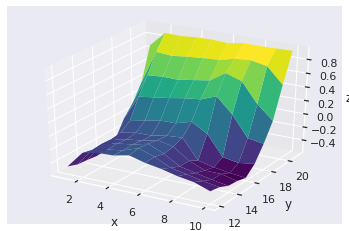

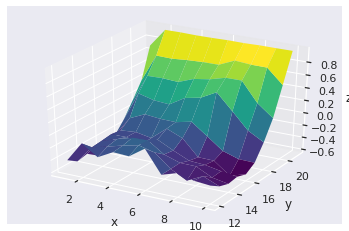

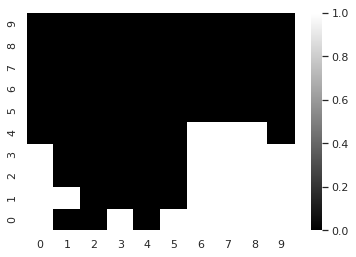

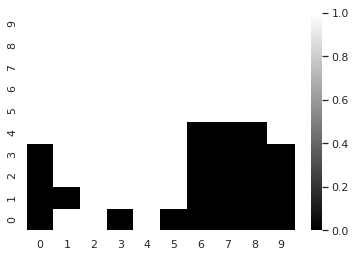

In [30]:
#Q4 Blackjack - part2

import random
import copy

############################################setup

#cards:1-13={Ace,2,3,4,5,6,7,8,9,10,10,10,10}

def deal_card():
    return min(random.randint(1,13),10)
    
    
class dealer():
    def __init__(self,face_up,current_sum,nonu_ace):
        self.face_up=face_up
        self.nonu_ace=nonu_ace
        self.u_ace=0
        self.current_sum=current_sum
        self.update(0)#pass a card number(pass a zero if you want to just update the ace situation)
    
    def update(self,card): #it should be 0<=card<=10
        self.current_sum+=card
        if(card==1 and self.current_sum<11):
            self.u_ace=1
            self.current_sum+=10
            
        if(self.nonu_ace>0 and self.current_sum+10<=21):
            self.nonu_ace-=1
            self.u_ace=1
            self.current_sum+=10
    
    def update_face_up(self,card):
        self.face_up=card
    
    def move(self):
        if(self.current_sum<17):
            return 1 #hit
        return 0 #stick
    
    def reset(self):
        self.face_up=0
        self.nonu_ace=0
        self.u_ace=0
        self.current_sum=0
        self.update(0)#pass a card number(pass a zero if you want to just update the ace situation)
    
    

class player():
    def __init__(self,current_sum,nonu_ace,policy):
        self.policy=policy #its data structure is same as the data structure of action_values
        self.nonu_ace=nonu_ace
        self.u_ace=0
        self.current_sum=current_sum
        self.update(0)#pass a card number(pass a zero if you want to just update the ace situation)
    
    def update(self,card): #it should be 0<=card<=10
        self.current_sum+=card;self.nonu_ace+=(card==1)
        if(card==1 and self.current_sum<11):
            self.u_ace=1
            self.nonu_ace-=1
            self.current_sum+=10
            
        if(self.nonu_ace>0 and self.current_sum+10<=21):
            self.nonu_ace-=1
            self.u_ace=1
            self.current_sum+=10
    
    def move(self,s): #this is the policy of the player, that takes a state tuple s, and outputs an action
        return self.policy[s][1]*1 #it is a deterministic policy
        
    def improve_pol(self,state,action_values): #takes in the state tuple regarding whom the policy needs to be updated, using the action_values
        greedy_act=(action_values[state][1]>action_values[state][0])*1
        self.policy[state][greedy_act]=1;self.policy[state][1-greedy_act]=0
    
    def get_policy(self):
        return self.policy
    
    def reset(self):
        self.nonu_ace=0
        self.u_ace=0
        self.current_sum=0
        self.update(0)#pass a card number(pass a zero if you want to just update the ace situation)
    
########################################################### initialization

# rewards = [0,1,-1]
    
action_values={} #state_values[s:(i,j,k)][a]
for i in range(2,22): #current states s: current_sum  of player
    for j in range(1,11): #current states s: dealer's showing card '1 is ace'
        for k in range(0,2): #current states s: user has usable ace or not '0 means no, 1 means yes'
            action_values[(i,j,k)]=random.randint(1,5)
            m=[random.randint(-1,1) for i in range(2)] #actions [0-stick, 1-hit]
            action_values[(i,j,k)]=m
        
gamma=1

#########################################################first-visit MC

def game_episode(Player,Dealer):
    
    #dealing cards
    face_up=deal_card()
    Dealer.update_face_up(face_up)
    Dealer.update(face_up);Dealer.update(deal_card())
    
    Player.update(deal_card());Player.update(deal_card())
    

    if(Player.current_sum==21):#handling the 'natural' case
        if(Dealer.current_sum==21):
            return [[(21,Dealer.face_up,Player.u_ace)],[0],[0]] 
        else:
            return [[(21,Dealer.face_up,Player.u_ace)],[0],[1]] 

    
    states=[(Player.current_sum,Dealer.face_up,Player.u_ace)]
    actions=[];rewards=[];flag=0;
    while(True):#player's turn
        
        if(flag==0):
            act=random.randint(0,1)
            flag=1
        else:
            act=Player.move(states[-1])
        actions.append(act)
        if(act==1):
            card=deal_card()
            Player.update(card)
        
        if(Player.current_sum>21 or act==0):
            break
        else:
            rewards.append(0)
            states.append((Player.current_sum,Dealer.face_up,Player.u_ace))
        
    if(Player.current_sum>21): #player bust
        rewards.append(-1)
    
    else: 
        while(True): #dealer's turn
            act=Dealer.move()
            if(act==0):
                break
            else:
                card=deal_card()
                Dealer.update(card)
                    
        if(Dealer.current_sum>21): #dealer bust
            rewards.append(1)
        else:
            rewards.append((Player.current_sum-Dealer.current_sum))
            if(rewards[-1]!=0):
                rewards[-1]//=abs(rewards[-1])
            
   
    return [states,actions,rewards]
        


def first_visit_MC(num_ep,gamma,Player,Dealer,action_values):
    
    v={} #initialization number of times those states were visited: v[(state)]=number
    for i in action_values:
        v[i]=[0,0]
    
    for ep in range(num_ep):
        Player.reset();Dealer.reset()
        
        [states,actions,rewards]=game_episode(Player,Dealer)
        G=0
        
        for i in range(len(rewards)-1,-1,-1):
            
            G=(gamma*G)+rewards[i]
            
            if(states[i] not in states[:i]): #for enforcing first visit MC
                
                #sample mean method of updation
                if(states[i] in v):
                    v[states[i]][actions[i]]+=1
                    action_values[states[i]][actions[i]]+=(G-action_values[states[i]][actions[i]])/v[states[i]][actions[i]]
                else:
                    v[states[i]]=[1-actions[i],actions[i]]
                    action_values[states[i]]=[(1-actions[i])*G,actions[i]*G]
                
                Player.improve_pol(states[i],action_values)
        
    return [action_values,Player.get_policy()]


#######################################################driver

initial_policy={} #action_values[s:(i,j,k)][a]
for i in range(2,22): #current states s: current_sum  of player
    for j in range(1,11): #current states s: dealer's showing card '1 is ace'
        for k in range(0,2): #current states s: user has usable ace or not '0 means no, 1 means yes'
            m=[((i<20)*t)+((i>=20)*(1-t)) for t in range(2)] #actions [0-stick, 1-hit]
            initial_policy[(i,j,k)]=m
            
Player=player(0,0,copy.deepcopy(initial_policy))
Dealer=dealer(0,0,0)
[estimate_actions,final_policy]=first_visit_MC(500000,gamma,Player,Dealer,copy.deepcopy(action_values)) #dictionary of estimated state values

###sanity checks:-
test_y1=[i[0] for i in estimate_actions];test_x1=[i[1] for i in estimate_actions];
assert(min(test_y1)>=2);
assert(min(test_x1)>=1);
assert(max(test_y1)<=21);
assert(max(test_x1)<=10)
test_y2=[i[0] for i in final_policy];test_x2=[i[1] for i in final_policy];
assert(min(test_y2)>=2);
assert(min(test_x2)>=1);
assert(max(test_y2)<=21);
assert(max(test_x2)<=10)

for i in estimate_actions:
    if(i[0]>=12):#i[2]==0 or 
        assert(max(estimate_actions[i])<=1)
        assert(min(estimate_actions[i])>=-1)

for i in final_policy:
    if(i[0]>=12):#i[2]==0 or
        assert((final_policy[i][0]==0 and final_policy[i][1]==1) or (final_policy[i][0]==1 and final_policy[i][1]==0))

for i in final_policy:
    if(i[0]>=12):#i[2]==0 or
        a=final_policy[i][1];print(i,a,estimate_actions[i][a])
        assert(estimate_actions[i][a]>=estimate_actions[i][1-a])
    
    
estimate={}
for i in estimate_actions:
    estimate[i]=max(estimate_actions[i])
assert(max(estimate.values())<=1)
assert(min(estimate.values())>=-1)


##################################################################plotting state_value functions

from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

z=[estimate[i] for i in estimate if(i[0]>=12)];#y=[i[0] for i in estimate if(i[0]>=12)]; x=[i[1] for i in estimate if(i[0]>=12)];print(min(x),min(y),max(x),max(y))

y=[i for i in range(12,22)]; x=[i for i in range(1,11)]

X, Y = np.meshgrid(x, y)

##########################################################optimal state-value functions for non-usable alpha

Z1=np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z1[i,j]=estimate[(Y[i,j],X[i,j],0)] #y-player sum, x-dealer face up

# print(type(Z),Z.shape,X.shape,np.min(X),np.min(Y))


fig = plt.figure("state-value functions for non-usable alpha")
ax = plt.axes(projection='3d')
# ax.plot_wireframe(X, Y, Z, color='black')
# ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z1, rstride=1, cstride=1,cmap='viridis',edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

##########################################################optimal state-value functions for usable alpha

Z=np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j]=estimate[(Y[i,j],X[i,j],1)] #y-player sum, x-dealer face up

# print(type(Z),Z.shape,X.shape,np.min(X),np.min(Y))


fig = plt.figure("state-value functions for usable alpha")
ax = plt.axes(projection='3d')
# ax.plot_wireframe(X, Y, Z, color='black')
# ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='viridis',edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

##################################################################plotting optimal policy for usable ace

print(X);print(Y)
import seaborn as sns; sns.set()
poll=np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        poll[i,j]=final_policy[(Y[i,j],X[i,j],0)][1] #y-player sum, x-dealer face up

fig = plt.figure("optimal policy for usable ace")
ax = sns.heatmap(poll,cmap="gray");ax.invert_yaxis()


##################################################################plotting optimal policy for non-usable ace

print(X);print(Y)
import seaborn as sns; sns.set()
poll1=np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        poll1[i,j]=final_policy[(Y[i,j],X[i,j],0)][0] #y-player sum, x-dealer face up

fig = plt.figure("optimal policy for non-usable ace")
ax = sns.heatmap(poll1,cmap="gray");ax.invert_yaxis()


#first plots for both are non-usable ace and second are usable

100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


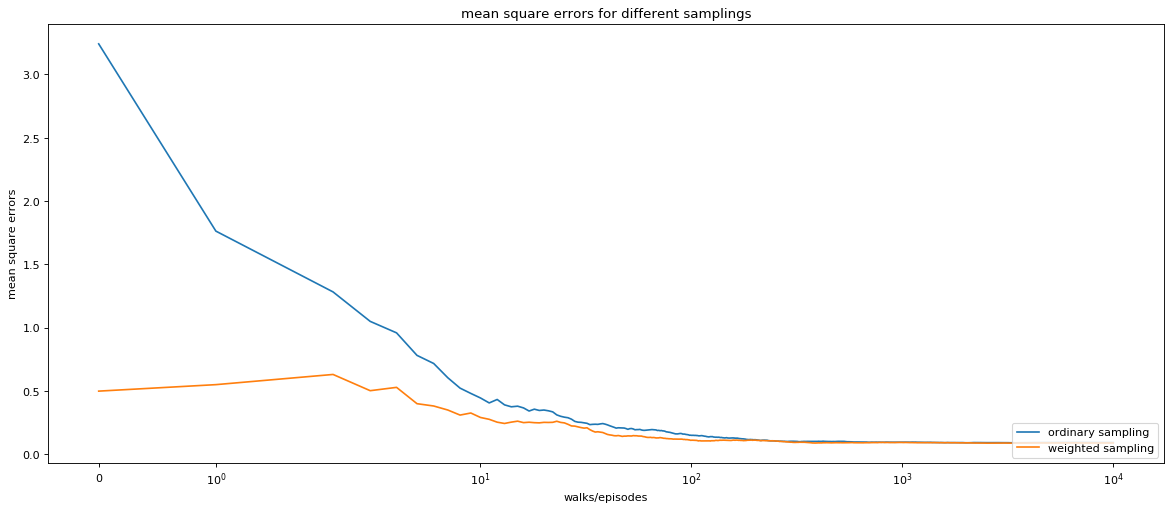

In [18]:
#Q4 Blackjack - part3

from tqdm import tqdm
import random
import copy
import numpy as np
from matplotlib import pyplot as plt

############################################setup

#cards:1-13={Ace,2,3,4,5,6,7,8,9,10,10,10,10}

def deal_card():
    return min(random.randint(1,13),10)
    
    
class dealer():
    def __init__(self,face_up,current_sum,nonu_ace):
        self.face_up=face_up
        self.nonu_ace=nonu_ace
        self.u_ace=0
        self.current_sum=current_sum
        self.update(0)#pass a card number(pass a zero if you want to just update the ace situation)
    
    def update(self,card): #it should be 0<=card<=10
        self.current_sum+=card
        if(card==1 and self.current_sum<11):
            self.u_ace=1
            self.current_sum+=10
            
        if(self.nonu_ace>0 and self.current_sum+10<=21):
            self.nonu_ace-=1
            self.u_ace=1
            self.current_sum+=10
    
    def update_face_up(self,card):
        self.face_up=card
    
    def move(self):
        if(self.current_sum<17):
            return 1 #hit
        return 0 #stick
    
    def reset(self):
        self.face_up=0
        self.nonu_ace=0
        self.u_ace=0
        self.current_sum=0
        self.update(0)#pass a card number(pass a zero if you want to just update the ace situation)
    
    

class player():
    def __init__(self,current_sum,nonu_ace):
        self.nonu_ace=nonu_ace
        self.u_ace=0
        self.current_sum=current_sum
        self.update(0)#pass a card number(pass a zero if you want to just update the ace situation)
    
    def update(self,card): #it should be 0<=card<=10
        self.current_sum+=card;self.nonu_ace+=(card==1)
        if(card==1 and self.current_sum<11):
            self.u_ace=1
            self.nonu_ace-=1
            self.current_sum+=10
            
        if(self.nonu_ace>0 and self.current_sum+10<=21):
            self.nonu_ace-=1
            self.u_ace=1
            self.current_sum+=10
    
    def move(self):
        return random.randint(0,1)
    
    def reset(self):
        self.nonu_ace=0
        self.u_ace=0
        self.current_sum=0
        self.update(0)#pass a card number(pass a zero if you want to just update the ace situation)
    
########################################################### initialization

# rewards = [0,1,-1]
    
state_values={} #state_values[s:(i,j,k)][a]
for i in range(2,22): #current states s: current_sum  of player
    for j in range(1,11): #current states s: dealer's showing card '1 is ace'
        for k in range(0,2): #current states s: user has usable ace or not '0 means no, 1 means yes'
            state_values[(i,j,k)]=0
            

targ_policy={} #action_values[s:(i,j,k)][a]
for i in range(2,22): #current states s: current_sum  of player
    for j in range(1,11): #current states s: dealer's showing card '1 is ace'
        for k in range(0,2): #current states s: user has usable ace or not '0 means no, 1 means yes'
            m=[((i<20)*t)+((i>=20)*(1-t)) for t in range(2)] #actions [0-stick, 1-hit]
            targ_policy[(i,j,k)]=m
for i in targ_policy:
    if(i[0]>=20):
        assert(targ_policy[i][0]==1 and targ_policy[i][1]==0)
    else:
        assert(targ_policy[i][0]==0 and targ_policy[i][1]==1)


        
gamma=1

#########################################################first-visit MC

def game_episode(Player,Dealer):
    
    #dealing cards
    face_up=2
    Dealer.update_face_up(face_up)
    Dealer.update(face_up);Dealer.update(deal_card())
    
    val=random.randint(1,2)
    if(val==1):
        Player.update(1);Player.update(2)
    else:
        Player.update(1);Player.update(1);Player.update(1)
    
    assert(Player.u_ace==1)

    if(Player.current_sum==21):#handling the 'natural' case
        if(Dealer.current_sum==21):
            return [[(21,Dealer.face_up,Player.u_ace)],[0],[0]] 
        else:
            return [[(21,Dealer.face_up,Player.u_ace)],[0],[1]] 

    
    states=[(Player.current_sum,Dealer.face_up,Player.u_ace)]
    actions=[];rewards=[]
    while(True):#player's turn
        
        act=Player.move()
        actions.append(act)
        if(act==1):
            card=deal_card()
            Player.update(card)
        
        if(Player.current_sum>21 or act==0):
            break
        else:
            rewards.append(0)
            states.append((Player.current_sum,Dealer.face_up,Player.u_ace))
        
    if(Player.current_sum>21): #player bust
        rewards.append(-1)
    
    else: 
        while(True): #dealer's turn
            act=Dealer.move()
            if(act==0):
                break
            else:
                card=deal_card()
                Dealer.update(card)
                    
        if(Dealer.current_sum>21): #dealer bust
            rewards.append(1)
        else:
            rewards.append((Player.current_sum-Dealer.current_sum))
            if(rewards[-1]!=0):
                rewards[-1]//=abs(rewards[-1])
            
   
    return [states,actions,rewards]
  

def first_visit_MC_ordinary_imp_sample(num_ep,gamma,Player,Dealer,state_values,targ_pol):
    list_of_state_vals=[] #holds the state value of the state we are interested in
    
    v={} #initialization number of times those states were visited: v[(state)]=number
    for i in state_values:
        v[i]=0
    
    for ep in range(num_ep):
        Player.reset();Dealer.reset()
        
        [states,actions,rewards]=game_episode(Player,Dealer)
#         y=[i[0] for i in states]; x=[i[1] for i in states];assert(min(x)>=1);
#         assert(max(x)<=10);
#         print(min(y));assert(min(y)>=1);
#         assert(max(y)<=21)
#         assert(len(states)==len(actions) and len(states)==len(rewards))
        G=0
        
        for i in range(len(rewards)-1,-1,-1):
            
            G=((gamma*G)+rewards[i])*(targ_pol[states[i]][actions[i]]/0.5)
            
#             if(states[i] not in states[:i]): #for enforcing first visit MC
                
            #sample mean method of updation
            if(states[i] in v):
                v[states[i]]+=1
                state_values[states[i]]+=((G)-state_values[states[i]])/v[states[i]]
            else:
                v[states[i]]=1
                state_values[states[i]]=G
        
        list_of_state_vals.append(state_values[(13,2,1)])
        
    return list_of_state_vals
    

def first_visit_MC_weighted_imp_sample(num_ep,gamma,Player,Dealer,state_values,targ_pol):
    list_of_state_vals=[] #holds the state value of the state we are interested in
    
    v={} #initialization of rho_values of those states were visited: v[(state)]=number
    for i in state_values:
        v[i]=0
    
    for ep in range(num_ep):
        Player.reset();Dealer.reset()
        
        [states,actions,rewards]=game_episode(Player,Dealer)
#         y=[i[0] for i in states]; x=[i[1] for i in states];assert(min(x)>=1);
#         assert(max(x)<=10);
#         print(min(y));assert(min(y)>=1);
#         assert(max(y)<=21)
#         assert(len(states)==len(actions) and len(states)==len(rewards))
        G=0
        
        for i in range(len(rewards)-1,-1,-1):
            v[states[i]]+=(targ_pol[states[i]][actions[i]]/0.5)
            G=((gamma*G)+rewards[i])*(targ_pol[states[i]][actions[i]]/0.5)
            
#             if(states[i] not in states[:i]): #for enforcing first visit MC
                
            #sample mean method of updation
            if(states[i] in v):
                state_values[states[i]]+=(((G)-state_values[states[i]])/max(v[states[i]]==0,v[states[i]]))*(v[states[i]]!=0)
            else:
                state_values[states[i]]=(G/max(v[states[i]]==0,v[states[i]]))*(v[states[i]]!=0) #basically if v[states[i]]==0, then divide by 1 instead
        
        list_of_state_vals.append(state_values[(13,2,1)])
        
    return list_of_state_vals


#######################################################driver for ordinary sampling

state_vals=[0 for i in range(10000)]
for i in tqdm(range(100)): #averaged over 100 runs, to control the high fluctuation in graph
    Player=player(0,0)
    Dealer=dealer(0,0,0)
    a1=first_visit_MC_ordinary_imp_sample(10000,gamma,Player,Dealer,copy.deepcopy(state_values),copy.deepcopy(targ_policy)) #dictionary of estimated state values
    
    for k in range(len(a1)):
        a1[k]=(a1[k]+0.27726)**2
    
    for j in range(len(a1)):
        state_vals[j]+=a1[j]/100

#######################################################driver for weighted sampling

state_vals_n=[0 for i in range(10000)]
for i in tqdm(range(100)): #averaged over 100 runs, to control the high fluctuation in graph
    Player=player(0,0)
    Dealer=dealer(0,0,0)
    a1=first_visit_MC_weighted_imp_sample(10000,gamma,Player,Dealer,copy.deepcopy(state_values),copy.deepcopy(targ_policy)) #dictionary of estimated state values
    
    for k in range(len(a1)):
        a1[k]=(a1[k]+0.27726)**2
    
    for j in range(len(a1)):
        state_vals_n[j]+=a1[j]/100        


##################################################################plotting ordinary sampling
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.title("mean square errors for different samplings");plt.xlabel("walks/episodes");plt.ylabel('mean square errors')
plt.plot([i for i in range(10000)],state_vals,label='ordinary sampling')

##################################################################plotting weighted sampling

plt.plot([i for i in range(10000)],state_vals_n,label='weighted sampling')
plt.xscale('symlog')

plt.legend(loc='lower right')


100%|██████████| 400/400 [01:09<00:00,  5.72it/s]


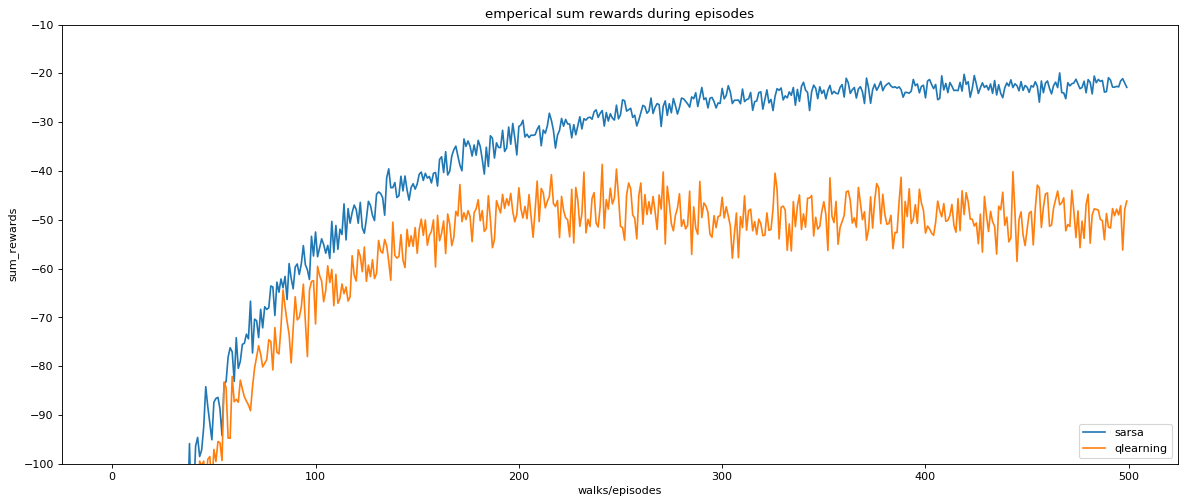

In [2]:
#cliff example compare Q-learning and SARSA

import random
import copy
from matplotlib import pyplot as plt
from tqdm import tqdm

############################################## MDP setup for simulated episode generation for MC

#actions are in this order: Up, Down, Left, Right

rewards=[0,-1,-100] #possible rewards at each state

p=[] #p[present state][actions][next state][rewards] 
for i in range(38):#s(0-37) 0-35:the normal 12x3 grid, 36:start, 37:goal
    hold=[]
    for j in range(4):#a(nswe)
        l=[]
        for k in range(38):#s'(0-37) 0-35:the normal 12x3 grid, 36:start, 37:goal
            m=[0 for o in range(3)] #r (0,-1,-100)
            l.append(m)            
        hold.append(l)
    p.append(hold)
    
        
for i in range(len(p)):
    for j in range(len(p[i])):
        if(i==37):
            p[i][j][37][0]=1
        elif(i==36):
            if(j==0):
                p[i][j][24][1]=1
            elif(j==1 or j==2):
                p[i][j][i][1]=1
            elif(j==3):
                p[i][j][36][2]=1  
        else:    
            if(j==0):
                if(i-12<0):
                    p[i][j][i][1]=1
                else:
                    p[i][j][i-12][1]=1
            elif(j==1):
                if(i==24):
                    p[i][j][36][1]=1
                elif(i==35):
                    p[i][j][37][1]=1
                elif(i>=25 and i<=35):
                    p[i][j][36][2]=1
                else:
                    p[i][j][i+12][1]=1
            elif(j==2):
                if(i==0 or i==12 or i==24):
                    p[i][j][i][1]=1
                else:
                    p[i][j][i-1][1]=1   
            elif(j==3):
                if(i==11 or i==23 or i==35):
                    p[i][j][i][1]=1
                else:
                    p[i][j][i+1][1]=1
                
        
        
#just verification of the MDP setup
for i in range(len(p)):
    for j in range(len(p[i])):
        su=0;count=1;
        for k in range(len(p[i][j])):
            for o in range(len(p[i][j][k])):
#                 print(k,o,p[i][j][k][o],count);count+=1
                su+=p[i][j][k][o]
#         if(su!=1):
#             print(i,j,su)
        assert(su==1)
        

gamma=1 #undiscounting

############################################### initialization

action_values=[] #action_values
for i in range(38):#s(0-37) 0-35:the normal 12x3 grid, 36:start, 37:goal
    hold=[]
    for j in range(4):#a(nswe)
        if(i==37): #terminal state
            hold.append(0)
        else:# for now, initializing all state values to 0
            hold.append(0)
    action_values.append(hold)

epsilon=0.1 #for the epsilon-soft behavioural policy
alpha=0.1 #constant step size

############################################# SARSA

def pick_action(state,policy,action_values): #based on the policy, action values and current state, returns an action
    assert(type(policy)==float and policy>=0 and policy<=1) #ensuring this, because for now, we will only need epsilon-greedy policy
    if(type(policy)==float and policy>=0 and policy<=1): #this implies an epsilon greedy policy
        val=random.uniform(0,1);
        if(val<=epsilon):
            return random.randint(0,3) #movement in any direction at random
        else:
            return action_values[state].index(max(action_values[state])) #movement in the maximizing direction
        
    
def sarsa(alpha,action_values,policy,p,num_ep,gamma,rewards): #policy parameter here takes the value of epsilon
    
    rewards_at_episodes=[] #holds the total accumulated reward(return starting from the initial state for that episode) for each episode 
    for ep in range(num_ep):
        s=36 #initial starting state
        act=pick_action(s,policy,action_values) #pick next action according to policy
#         print(ep,'ep',s,'s',act,'act')
        acc=0 #accumulates all the rewards for this particular episode
        while(s!=37): #stay in this episode till the goal is hit
#             print(ep,'ep while')
            r=0;s_n=0 #next state and reward
            for i in range(len(p[s][act])):
                flag=0
                for j in range(len(p[s][act][i])):
                    if(p[s][act][i][j]==1):
                        r=rewards[j];s_n=i;flag=1
                        break
                if(flag==1):
                    break
            acc+=r #reward accumulated
            
            act_n=pick_action(s_n,policy,action_values) #next action
#             print(r,'r')
            bootstrap=gamma*action_values[s_n][act_n] #bootstrapping using the next state-action pair
            action_values[s][act]+=alpha*(r + bootstrap - action_values[s][act])
            
            s=s_n;act=act_n
#             print(s_n,'s_n',act_n,'act_n')
        
        rewards_at_episodes.append(acc) #sum reward for this episode recorded
    
    return rewards_at_episodes

################################################## Q LEARNING        
    
def qlearning(alpha,action_values,policy,p,num_ep,gamma,rewards): #policy here takes the value of epsilon
    
    rewards_at_episodes=[] #holds the total accumulated reward(return starting from the initial state for that episode) for each episode
    for ep in range(num_ep):
        s=36 #initial starting state
        act=pick_action(s,policy,action_values) #pick next action according to policy
#         print(ep,'ep',s,'s',act,'act')
        acc=0 #accumulates all the rewards for this particular episode
        while(s!=37): #stay in this episode till the goal is hit
#             print(ep,'ep while')
            r=0;s_n=0 #next state and reward
            for i in range(len(p[s][act])):
                flag=0
                for j in range(len(p[s][act][i])):
                    if(p[s][act][i][j]==1):
                        r=rewards[j];s_n=i;flag=1
                        break
                if(flag==1):
                    break
            acc+=r #reward accumulated
            
            act_n=pick_action(s_n,policy,action_values) #next action
#             print(r,'r')
            bootstrap=gamma*max(action_values[s_n]) #bootstrapping using the maximizing action of next state
            action_values[s][act]+=alpha*(r + bootstrap - action_values[s][act])
            
            s=s_n;act=act_n
#             print(s_n,'s_n',act_n,'act_n')
        
        rewards_at_episodes.append(acc) #sum reward for this episode recorded
    
    return rewards_at_episodes



##################################################driver sarsa

sum_rewards=[0 for i in range(500)];
for i in tqdm(range(400)): #averaged over 400 runs, to control the high fluctuation in graph
    a1=sarsa(alpha, copy.deepcopy(action_values),epsilon,p,500,gamma,rewards)
    
    for j in range(len(a1)):
        sum_rewards[j]+=a1[j]/400
        

#################################################plotter sarsa

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.title("emperical sum rewards during episodes");plt.xlabel("walks/episodes");plt.ylabel('sum_rewards')
plt.plot([i for i in range(len(sum_rewards))],sum_rewards,label='sarsa')

#################################################driver qlearning

sum_rewards_new=[0 for i in range(500)];
for i in tqdm(range(400)): #averaged over 400 runs, to control the high fluctuation in graph
    a1=qlearning(alpha, copy.deepcopy(action_values),epsilon,p,500,gamma,rewards)
    
    for j in range(len(a1)):
        sum_rewards_new[j]+=a1[j]/400

#################################################plotter qlearning

plt.plot([i for i in range(len(sum_rewards_new))],sum_rewards_new,label='qlearning')

plt.ylim([-100,-10])
plt.legend(loc='lower right')

